# 1. Retrieving the Data

## 1.1 Load Libraries

In [374]:
import pandas as pd
import numpy as np
import seaborn as sns
import re as re
import matplotlib.pyplot as plt
import os
import glob

from plotly.offline import init_notebook_mode, iplot
from plotly.subplots import make_subplots
import plotly.offline as py
import plotly.graph_objs as go

from sklearn import preprocessing
# Supress unnecessary warnings so that presentation looks clean
import warnings
warnings.filterwarnings("ignore")


from wordcloud import WordCloud
from datetime import datetime, timezone, timedelta

## 1.2 Read the Data

In [375]:
path = os.getcwd()
csv_files = glob.glob(os.path.join(f'{path}\Raw_Data', "*.csv"))
  
lst=[]

for file in csv_files:
    
    temp_csv = pd.read_csv(file, index_col=None, header=0)
    lst.append(temp_csv)
    
data = pd.concat(lst, axis=0, ignore_index=True)    

# 2. Overview of Data

In [376]:
data.head()

,Title,Title_URL,Image,Price,location,Date,Description,intersection,intersection1,bedrooms,Current_Time
0,\n Furnished rental...,https://www.kijiji.ca/v-short-term-rental/city...,https://ca.classistatic.com/static/V/10733/img...,\n \n ...,\n \n ...,11/12/2021,\n Available January 15...,Bloor Street West,Durie Street,NaN,2021-12-14 19:28:16.681
1,\n Look for a Real...,https://www.kijiji.ca/v-real-estate-service/ci...,https://ca.classistatic.com/static/V/10733/img...,\n \n ...,\n \n ...,08/12/2021,\n Are you looking for ...,NaN,NaN,NaN,2021-12-14 19:28:17.822
2,\n RENT TO OWN A HO...,https://www.kijiji.ca/v-apartments-condos/city...,https://ca.classistatic.com/static/V/10733/img...,\n \n ...,\n \n ...,11/12/2021,\n Program # 1 -- Buy H...,Airport Road,Thamesgate Drive,\n \n ...,2021-12-14 19:28:18.641
3,\n 2 Bedroom - 1 Ba...,https://www.kijiji.ca/v-apartments-condos/king...,https://ca.classistatic.com/static/V/10733/img...,\n \n ...,\n \n ...,13/11/2021,\n Stunning renovations...,King Street West,Mowat Avenue,\n \n ...,2021-12-14 19:28:19.105
4,\n Country Living A...,https://www.kijiji.ca/v-house-for-sale/st-cath...,https://ca.classistatic.com/static/V/10733/img...,\n \n ...,\n \n ...,Yesterday,\n Country Living At It...,Louth 5th Street,St Paul Street West,NaN,2021-12-14 19:28:21.979


The data needs to be.....

In [377]:
data=data.rename(columns={"location":"Location",
                          "Date": "Time_Posted",
                          "intersection": "Intersection_1",
                          "intersection1": "Intersection_2",
                          "bedrooms":"Bedrooms", 
                          "Current_Time":"Time_Retrieved"})



# 3. Data Preparation

In [378]:
#Remove extra spaces before and after while excluding non-stirng items 
for col in data.columns:
    try:
      data[col]=data[col].apply(lambda x : x.strip())
    except AttributeError:
      print("{}".format(col))
    
print("=============================================================================")
    
data["Listing_Type"]= data["Title_URL"].str.extract(r"(/v.*?/)", expand=True)
data['Listing_Type'] = data['Listing_Type'].map(lambda x: x.lstrip('/v-').rstrip('/').title())
set(data["Listing_Type"])

print(data.columns)

Image
Intersection_1
Intersection_2
Bedrooms
Index(['Title', 'Title_URL', 'Image', 'Price', 'Location', 'Time_Posted',
       'Description', 'Intersection_1', 'Intersection_2', 'Bedrooms',
       'Time_Retrieved', 'Listing_Type'],
      dtype='object')


## 3.1 Time

In [379]:
#Convert Time to EST

data['Time_Retrieved'] = pd.to_datetime(data['Time_Retrieved'])
data['Time_Retrieved']=data['Time_Retrieved'].dt.tz_localize('UTC')
data['Time_Retrieved']=data['Time_Retrieved'].dt.tz_convert('US/Eastern')



def find_number(text):
    num = re.findall(r'[0-9]+',text)
    
    if len("".join(num))>2 or len("".join(num))==0:
        return 0
    else:
        return int("".join(num))
    

def _convert_time_posted_string_to_datetime():

    data['Number']=data['Time_Posted'].apply(lambda x: find_number(x))
    data['Number']=data['Number'].astype(int)

    units=['second','minute','hour']

    for unit in units:
        #check if string contains unit
        data['Temp_Time']= data['Time_Posted'].str.contains(unit)

        #subtract number as a datetime object from time retrieved
        data.loc[data.Temp_Time==True, 'Number']=pd.to_timedelta(data['Number'], unit=unit[0])

    #Converting 'Yesterday'    
    data['Temp_Time']= data['Time_Posted'].map(lambda x: x=='Yesterday')
    data.loc[data.Temp_Time==True, 'Number']=pd.to_timedelta(1.25, unit='d')

    #Leaving other dates as is
    data['Temp_Time']= data['Number'].map(lambda x: x==0)
    data.loc[data.Temp_Time==True, 'Number']=pd.to_timedelta(0, unit='d')    


    data.loc[data.Temp_Time==False, 'Time_Posted']=data['Time_Retrieved']-data['Number']  
    


_convert_time_posted_string_to_datetime()


data['Time_Posted']=pd.to_datetime(data['Time_Posted'], utc=True)
data['Time_Posted']=data['Time_Posted'].dt.tz_convert('US/Eastern')


data["Month"] = data["Time_Posted"].dt.month
data['Day_of_Week'] = data['Time_Posted'].dt.day_name()
data['Day_of_Month'] = data['Time_Posted'].dt.day
data["Year_Day"] = data['Time_Posted'].dt.dayofyear


data

,Title,Title_URL,Image,Price,Location,Time_Posted,Description,Intersection_1,Intersection_2,Bedrooms,Time_Retrieved,Listing_Type,Number,Temp_Time,Month,Day_of_Week,Day_of_Month,Year_Day
0,Furnished rental 2 bedroom 2 bathroom 2 level ...,https://www.kijiji.ca/v-short-term-rental/city...,https://ca.classistatic.com/static/V/10733/img...,"$2,800.00",City of Toronto,2021-11-11 19:00:00-05:00,"Available January 15, 2022. Furnished accomoda...",Bloor Street West,Durie Street,NaN,2021-12-14 14:28:16.681000-05:00,Short-Term-Rental,0 days 00:00:00,True,11,Thursday,11,315
1,Look for a Real Estate Agent? ***19 Years Ex...,https://www.kijiji.ca/v-real-estate-service/ci...,https://ca.classistatic.com/static/V/10733/img...,,City of Toronto,2021-08-11 20:00:00-04:00,Are you looking for a Real Estate Agent? I hav...,NaN,NaN,NaN,2021-12-14 14:28:17.822000-05:00,Real-Estate-Service,0 days 00:00:00,True,8,Wednesday,11,223
2,RENT TO OWN A HOUSE OR BUY WITH OUR ZERO DOWN ...,https://www.kijiji.ca/v-apartments-condos/city...,https://ca.classistatic.com/static/V/10733/img...,"$2,500.00",City of Toronto,2021-11-11 19:00:00-05:00,Program # 1 -- Buy House With Our Zero Down Pr...,Airport Road,Thamesgate Drive,\n \n ...,2021-12-14 14:28:18.641000-05:00,Apartments-Condos,0 days 00:00:00,True,11,Thursday,11,315
3,"2 Bedroom - 1 Bath Condo - 1 Mowat Ave, 3rd fl...",https://www.kijiji.ca/v-apartments-condos/king...,https://ca.classistatic.com/static/V/10733/img...,"$2,450.00",Kingston,2021-11-12 19:00:00-05:00,Stunning renovations throughout. 2 Bedroom (la...,King Street West,Mowat Avenue,\n \n ...,2021-12-14 14:28:19.105000-05:00,Apartments-Condos,0 days 00:00:00,True,11,Friday,12,316
4,Country Living At Its Finest! 5 Acres In Heart...,https://www.kijiji.ca/v-house-for-sale/st-cath...,https://ca.classistatic.com/static/V/10733/img...,"$1,499,900.00",St. Catharines,2021-12-13 08:28:21.979000-05:00,Country Living At Its Finest! 5 Acres In The H...,Louth 5th Street,St Paul Street West,NaN,2021-12-14 14:28:21.979000-05:00,House-For-Sale,1 days 06:00:00,False,12,Monday,13,347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17995,Toronto/Mississauga-1 B/B &Kitchenette: Monthl...,https://www.kijiji.ca/v-short-term-rental/miss...,https://ca.classistatic.com/static/V/10760/img...,"$1,365.00",Mississauga / Peel Region,2022-01-07 11:13:02.199000-05:00,Independent Unit With Side Entrance__ Maximum ...,Glen Erin Drive,Quails Run,NaN,2022-01-08 08:13:02.199000-05:00,Short-Term-Rental,0 days 21:00:00,False,1,Friday,7,7
17996,All-inclusive access to coworking space in Tor...,https://www.kijiji.ca/v-commercial-office-spac...,https://ca.classistatic.com/static/V/10760/img...,$518.00,City of Toronto,2022-01-07 11:13:02.648000-05:00,Get to work among a like-minded community in o...,Bay Street,Cumberland Street,NaN,2022-01-08 08:13:02.648000-05:00,Commercial-Office-Space,0 days 21:00:00,False,1,Friday,7,7
17997,Virtual office in Toronto Yorkville,https://www.kijiji.ca/v-commercial-office-spac...,https://ca.classistatic.com/static/V/10760/img...,$244.00,City of Toronto,2022-01-07 11:13:02.723000-05:00,"Build your business presence fast, with an ins...",Bay Street,Cumberland Street,NaN,2022-01-08 08:13:02.723000-05:00,Commercial-Office-Space,0 days 21:00:00,False,1,Friday,7,7
17998,2 BED + DEN / 1 BATH + LAUNDRY NEWLY RENOVATED,https://www.kijiji.ca/v-apartments-condos/hami...,https://ca.classistatic.com/static/V/10760/img...,"$1,950.00",Hamilton,2022-01-07 11:13:02.796000-05:00,"St. Clair Neighbourhood, Hamilton Enjoy a well...",Main Street East,Fairleigh Avenue South,\n \n ...,2022-01-08 08:13:02.796000-05:00,Apartments-Condos,0 days 21:00:00,False,1,Friday,7,7


In [380]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype                     
---  ------          --------------  -----                     
 0   Title           18000 non-null  object                    
 1   Title_URL       18000 non-null  object                    
 2   Image           17120 non-null  object                    
 3   Price           18000 non-null  object                    
 4   Location        18000 non-null  object                    
 5   Time_Posted     18000 non-null  datetime64[ns, US/Eastern]
 6   Description     18000 non-null  object                    
 7   Intersection_1  14874 non-null  object                    
 8   Intersection_2  14874 non-null  object                    
 9   Bedrooms        9926 non-null   object                    
 10  Time_Retrieved  18000 non-null  datetime64[ns, US/Eastern]
 11  Listing_Type    18000 non-null  object                

In [381]:
#Add types
temp = data["Listing_Type"].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Distribution of differnet Ad Types')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

In [382]:
temp = data["Location"].value_counts().head(20)
print('Top 5 Ad cities :\n', temp.head(5))
print("Total Ad cities : ",len(data["Location"]))
trace = go.Bar(
    x = temp.index,
    y = temp.values,
)

layout = go.Layout(
    title = "Top Ad city",
    xaxis=dict(
        title='Regions',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count of Ad cities',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

Top 5 Ad cities :
 City of Toronto              5938
Mississauga / Peel Region    2706
Ottawa                       2310
Markham / York Region         683
London                        619
Name: Location, dtype: int64
Total Ad cities :  18000


In [383]:
temp = data["Day_of_Week"].value_counts().head(20)
trace = go.Bar(
    x = temp.index,
    y = temp.values,
)

layout = go.Layout(
    title = "Days of Week",
    xaxis=dict(
        title='Weekdays',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count of Postings',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

In [384]:
temp = data["Day_of_Month"].value_counts().head(20)
trace = go.Bar(
    x = temp.index,
    y = temp.values,
)

layout = go.Layout(
    title = "Days of Month",
    xaxis=dict(
        title='Day',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count of Postings',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

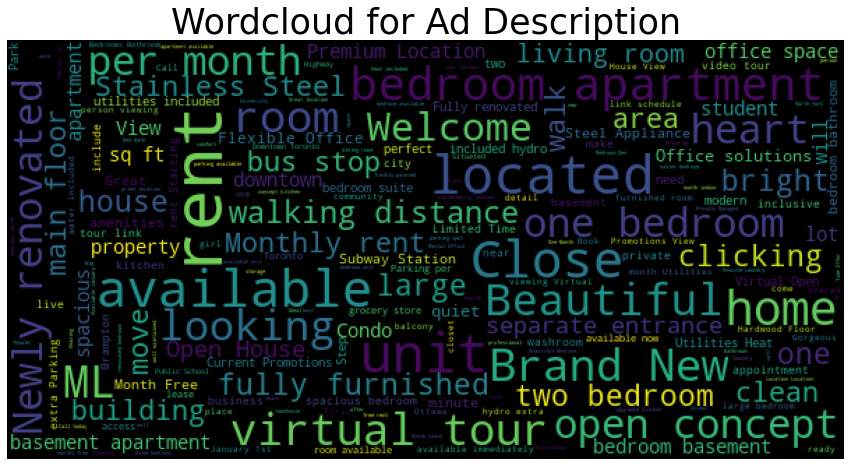

In [385]:
# from wordcloud import WordCloud, STOPWORDS
names = data["Description"][~pd.isnull(data["Description"])]
#print(names)
wordcloud = WordCloud(max_font_size=50, width=600, height=300).generate(' '.join(names))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.title("Wordcloud for Ad Description", fontsize=35)
plt.axis("off")
plt.show() 

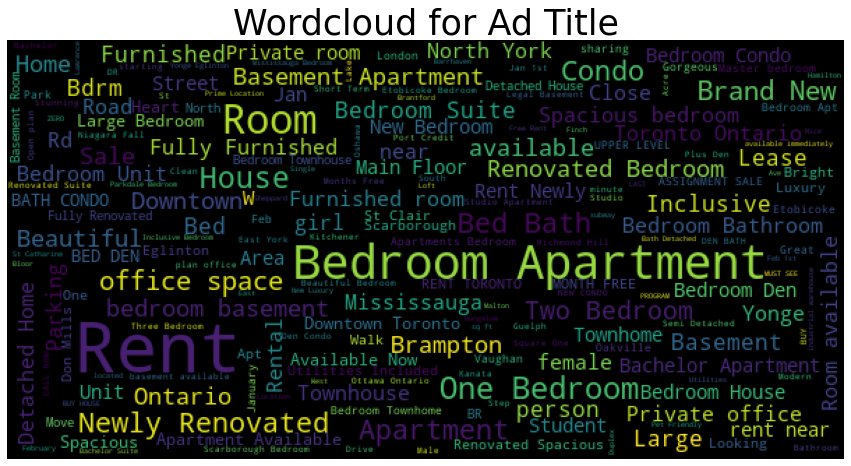

In [386]:
# from wordcloud import WordCloud, STOPWORDS
names = data["Title"][~pd.isnull(data["Title"])]
#print(names)
wordcloud = WordCloud(max_font_size=50, width=600, height=300).generate(' '.join(names))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.title("Wordcloud for Ad Title", fontsize=35)
plt.axis("off")
plt.show() 

## 3.? Price

In [387]:
data['Price']=data['Price'].replace('[\$,\s]', '', regex=True)
data['Price']=data['Price'].replace(r'^\s*$', np.nan, regex=True)


data.loc[(data['Price'].str.contains('[\d]+\.[\d]+\.[\d]+', regex=True)==True) 
         | (data['Price'].str.contains('[a-zA-Z]+', regex=True)==True)
         | (data['Price'].isnull()==True)]
                 

index_names = data[(data['Price'].str.contains('[\d]+\.[\d]+\.[\d]+', regex=True)==True) 
                   | (data['Price'].str.contains('[a-zA-Z]+', regex=True)==True)
                   | (data['Price'].isnull()==True)].index


data.drop(index_names, inplace=True)

data['Price']=data['Price'].astype(float)


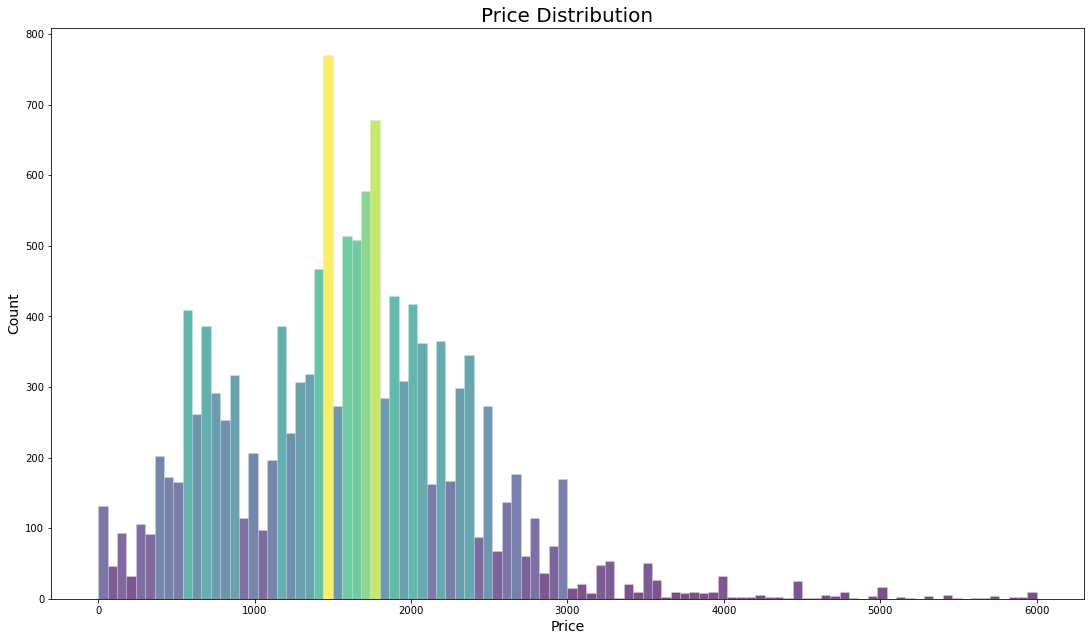

In [388]:
data_Reduced = data[data.Price <= 6000]


fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
n, bins, patches = plt.hist(data_Reduced.Price, bins=100, facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)
n = n.astype('int') # it MUST be integer
for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.viridis(n[i]/max(n)))
plt.title('Price Distribution', fontsize=20)
plt.xlabel('Price', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

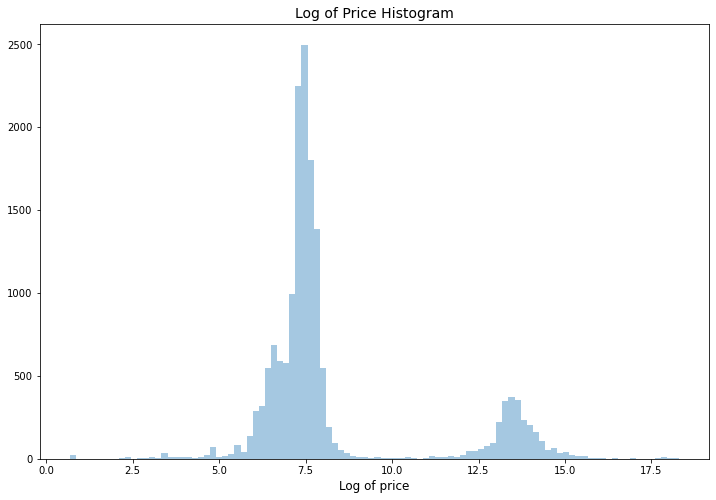

In [389]:
plt.figure(figsize=(12,8))
sns.distplot(np.log1p(data["Price"].values), bins=100, kde=False)
plt.xlabel('Log of price', fontsize=12)
plt.title("Log of Price Histogram", fontsize=14)
plt.show()

## Creating features from Ad Description and Title

In [390]:
data['desc_char_count'] = data['Description'].apply(len)
data['desc_word_count'] = data['Description'].apply(lambda x: len(x.split()))
data['desc_word_density'] = data['desc_char_count'] / (data['desc_word_count']+1)
data['desc_title_word_count'] = data['Description'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
data['desc_upper_case_word_count'] = data['Description'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))

data['_title_char_count'] = data['Title'].apply(len)
data['_title_word_count'] = data['Title'].apply(lambda x: len(x.split()))
data['_title_word_density'] = data['_title_word_count'] / (data['_title_word_count']+1)
data['_title_word_count'] = data['Title'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
data['_title_upper_case_word_count'] = data['Title'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))

In [391]:
data['Image_Available']=data['Image'].notnull()

data

,Title,Title_URL,Image,Price,Location,Time_Posted,Description,Intersection_1,Intersection_2,Bedrooms,...,desc_char_count,desc_word_count,desc_word_density,desc_title_word_count,desc_upper_case_word_count,_title_char_count,_title_word_count,_title_word_density,_title_upper_case_word_count,Image_Available
0,Furnished rental 2 bedroom 2 bathroom 2 level ...,https://www.kijiji.ca/v-short-term-rental/city...,https://ca.classistatic.com/static/V/10733/img...,2800.0,City of Toronto,2021-11-11 19:00:00-05:00,"Available January 15, 2022. Furnished accomoda...",Bloor Street West,Durie Street,NaN,...,199,31,6.218750,6,0,64,1,0.916667,0,True
2,RENT TO OWN A HOUSE OR BUY WITH OUR ZERO DOWN ...,https://www.kijiji.ca/v-apartments-condos/city...,https://ca.classistatic.com/static/V/10733/img...,2500.0,City of Toronto,2021-11-11 19:00:00-05:00,Program # 1 -- Buy House With Our Zero Down Pr...,Airport Road,Thamesgate Drive,\n \n ...,...,196,36,5.297297,24,0,53,1,0.923077,12,True
3,"2 Bedroom - 1 Bath Condo - 1 Mowat Ave, 3rd fl...",https://www.kijiji.ca/v-apartments-condos/king...,https://ca.classistatic.com/static/V/10733/img...,2450.0,Kingston,2021-11-12 19:00:00-05:00,Stunning renovations throughout. 2 Bedroom (la...,King Street West,Mowat Avenue,\n \n ...,...,203,28,7.000000,9,0,60,6,0.933333,0,True
4,Country Living At Its Finest! 5 Acres In Heart...,https://www.kijiji.ca/v-house-for-sale/st-cath...,https://ca.classistatic.com/static/V/10733/img...,1499900.0,St. Catharines,2021-12-13 08:28:21.979000-05:00,Country Living At Its Finest! 5 Acres In The H...,Louth 5th Street,St Paul Street West,NaN,...,196,37,5.157895,30,0,64,11,0.923077,0,True
5,All Inclusive Bachelor Available! (Lawrence Av...,https://www.kijiji.ca/v-apartments-condos/city...,https://ca.classistatic.com/static/V/10733/img...,1300.0,City of Toronto,2021-12-14 14:27:22.699000-05:00,"550 Scarborough Golf Club Rd., Scarborough Law...",Holmfirth Terrace,Vanwart Drive,\n \n ...,...,199,36,5.378378,17,0,63,8,0.900000,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17995,Toronto/Mississauga-1 B/B &Kitchenette: Monthl...,https://www.kijiji.ca/v-short-term-rental/miss...,https://ca.classistatic.com/static/V/10760/img...,1365.0,Mississauga / Peel Region,2022-01-07 11:13:02.199000-05:00,Independent Unit With Side Entrance__ Maximum ...,Glen Erin Drive,Quails Run,NaN,...,201,32,6.090909,18,6,54,4,0.833333,1,True
17996,All-inclusive access to coworking space in Tor...,https://www.kijiji.ca/v-commercial-office-spac...,https://ca.classistatic.com/static/V/10760/img...,518.0,City of Toronto,2022-01-07 11:13:02.648000-05:00,Get to work among a like-minded community in o...,Bay Street,Cumberland Street,NaN,...,532,40,12.975610,7,0,60,2,0.888889,0,True
17997,Virtual office in Toronto Yorkville,https://www.kijiji.ca/v-commercial-office-spac...,https://ca.classistatic.com/static/V/10760/img...,244.0,City of Toronto,2022-01-07 11:13:02.723000-05:00,"Build your business presence fast, with an ins...",Bay Street,Cumberland Street,NaN,...,532,36,14.378378,6,0,35,3,0.833333,0,True
17998,2 BED + DEN / 1 BATH + LAUNDRY NEWLY RENOVATED,https://www.kijiji.ca/v-apartments-condos/hami...,https://ca.classistatic.com/static/V/10760/img...,1950.0,Hamilton,2022-01-07 11:13:02.796000-05:00,"St. Clair Neighbourhood, Hamilton Enjoy a well...",Main Street East,Fairleigh Avenue South,\n \n ...,...,200,30,6.451613,8,0,46,0,0.916667,6,True


## Convert Categorical features to numerical

In [392]:
# Label encode the categorical variables
cat_vars = ["Location", "Image_Available", "Day_of_Week", "Listing_Type"]
for col in cat_vars:
    lb = preprocessing.LabelEncoder()
    lb.fit(list(data[col].values.astype('str')))
    data[col] = lb.transform(list(data[col].values.astype('str')))
    

In [393]:
data.columns

Index(['Title', 'Title_URL', 'Image', 'Price', 'Location', 'Time_Posted',
       'Description', 'Intersection_1', 'Intersection_2', 'Bedrooms',
       'Time_Retrieved', 'Listing_Type', 'Number', 'Temp_Time', 'Month',
       'Day_of_Week', 'Day_of_Month', 'Year_Day', 'desc_char_count',
       'desc_word_count', 'desc_word_density', 'desc_title_word_count',
       'desc_upper_case_word_count', '_title_char_count', '_title_word_count',
       '_title_word_density', '_title_upper_case_word_count',
       'Image_Available'],
      dtype='object')

In [394]:
cols_to_drop=['Title', 'Title_URL', 'Image', 'Description', 'Intersection_1', 'Intersection_2', 'Bedrooms', 
              'Time_Retrieved', 'Number', 'Temp_Time',]

data_df = data.drop(cols_to_drop, axis=1)

data_df

,Price,Location,Time_Posted,Listing_Type,Month,Day_of_Week,Day_of_Month,Year_Day,desc_char_count,desc_word_count,desc_word_density,desc_title_word_count,desc_upper_case_word_count,_title_char_count,_title_word_count,_title_word_density,_title_upper_case_word_count,Image_Available
0,2800.0,13,2021-11-11 19:00:00-05:00,7,11,4,11,315,199,31,6.218750,6,0,64,1,0.916667,0,1
2,2500.0,13,2021-11-11 19:00:00-05:00,0,11,4,11,315,196,36,5.297297,24,0,53,1,0.923077,12,1
3,2450.0,26,2021-11-12 19:00:00-05:00,0,11,0,12,316,203,28,7.000000,9,0,60,6,0.933333,0,1
4,1499900.0,67,2021-12-13 08:28:21.979000-05:00,4,12,1,13,347,196,37,5.157895,30,0,64,11,0.923077,0,1
5,1300.0,13,2021-12-14 14:27:22.699000-05:00,0,12,5,14,348,199,36,5.378378,17,0,63,8,0.900000,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17995,1365.0,38,2022-01-07 11:13:02.199000-05:00,7,1,0,7,7,201,32,6.090909,18,6,54,4,0.833333,1,1
17996,518.0,13,2022-01-07 11:13:02.648000-05:00,1,1,0,7,7,532,40,12.975610,7,0,60,2,0.888889,0,1
17997,244.0,13,2022-01-07 11:13:02.723000-05:00,1,1,0,7,7,532,36,14.378378,6,0,35,3,0.833333,0,1
17998,1950.0,22,2022-01-07 11:13:02.796000-05:00,0,1,0,7,7,200,30,6.451613,8,0,46,0,0.916667,6,1


In [395]:
df = [
    go.Heatmap(
        z= data_df.corr().values,
        x=data_df.columns.values,
        y=data_df.columns.values,
        colorscale='Viridis',
        reversescale = False,
        opacity = 1.0 )
]

layout = go.Layout(
    title='Pearson Correlation of features',
    xaxis = dict(ticks='', nticks=36),
    yaxis = dict(ticks='' ),
    width = 900, height = 700)

fig = go.Figure(data=df, layout=layout)
py.iplot(fig, filename='labelled-heatmap')